# GS Stock Price Prediction

Based on stock analysis detailed here: 
https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7
and supplemented by information detailed here:
https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f 

In [5]:
import datetime
import math
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn import preprocessing

#df = pd.read_csv("GS.csv")
start = datetime.datetime(2010, 1, 1)
end = datetime.date.today()
df = web.DataReader("GS", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-09,213.880005,208.440002,209.220001,211.979996,2734500.0,211.979996
2019-09-10,217.089996,213.220001,213.500000,215.630005,2615800.0,215.630005
2019-09-11,216.850006,213.360001,215.210007,216.800003,1886300.0,216.800003
2019-09-12,220.759995,215.149994,216.380005,218.740005,2913800.0,218.740005
2019-09-13,221.500000,219.199997,220.350006,219.899994,2679900.0,219.899994


## Rolling Mean

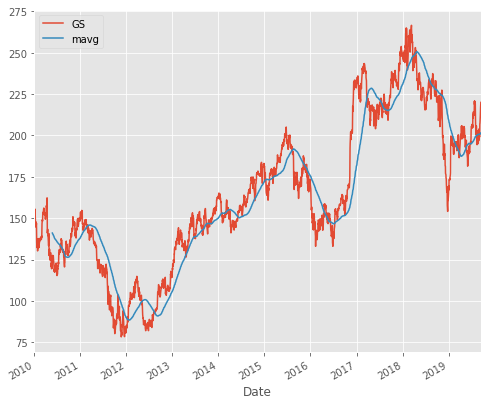

In [6]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='GS')
mavg.plot(label='mavg')
plt.legend()

## Returns Deviation

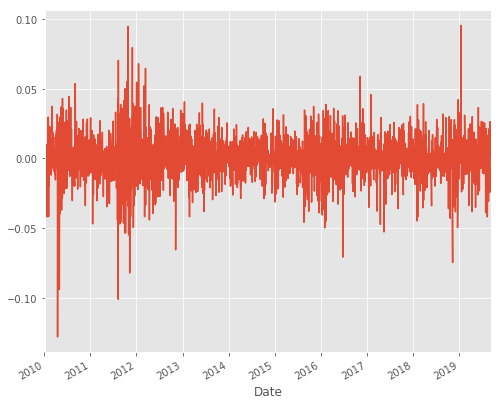

In [7]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

## Feature Engineering

In [0]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

## Preprocessing & Cross Validation

In [0]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))### drops last and stores the rest in X
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])  ## labels only in y
tempp=y
y = y[:-forecast_out]

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

In [114]:
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change,label
Date,,,,,
2010-01-04,151.511627,9135000.0,2.738621,1.781828,133.487457
2010-01-05,154.190262,11659400.0,2.094917,1.815029,134.485352
2010-01-06,152.544586,7381100.0,0.929651,-0.638619,134.852997
2010-01-07,155.529587,8727400.0,2.701640,1.921748,134.747940
2010-01-08,152.588318,7268100.0,1.996441,-1.145582,137.785553


## Model Generation & Evaluation

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Linear regression

In [116]:
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
confidencereg = clfreg.score(X_test, y_test)

'The linear regression confidence is {0}'.format(confidencereg)

'The linear regression confidence is 0.9091546827091842'

### Quadratic Regression 2

In [117]:
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)
confidencepoly2 = clfpoly2.score(X_test,y_test)

'The quadratic regression 2 confidence is {0}'.format(confidencepoly2)

'The quadratic regression 2 confidence is 0.9101953487724852'

### Quadratic Regression 3

In [118]:
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)
confidencepoly3 = clfpoly3.score(X_test,y_test)

'The quadratic regression 3 confidence is {0}'.format(confidencepoly3)

'The quadratic regression 3 confidence is 0.9079241731550547'

### KNN Regression

In [119]:
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)
confidenceknn = clfknn.score(X_test, y_test)

'The knn regression confidence is {0}'.format(confidenceknn)

'The knn regression confidence is 0.8754302922689444'

### Lasso

In [120]:
clflass = Lasso(alpha=0.1)
clflass.fit(X_train, y_train)
confidencelass = clflass.score(X_test, y_test)

'The lasso confidence is {0}'.format(confidencelass)

'The lasso confidence is 0.9091203128008004'

### Ridge

In [121]:
clfridge = Ridge(alpha=0.5)
clfridge.fit(X_train, y_train)
confidenceridge = clfridge.score(X_test, y_test)

'The ridge confidence is {0}'.format(confidenceridge)

'The ridge confidence is 0.9091456919690027'

## Prediction

### Linear Regression Prediction

In [122]:
forecast_reg = clfreg.predict(X_lately)
dfreg['Forecast_Reg'] = np.nan

forecast_reg

array([204.99523378, 200.06271124, 202.15590369, 193.84628805,
       194.90190308, 197.97441114, 200.7072552 , 198.67947641,
       199.42539803, 201.0540032 , 194.61612011, 198.4468757 ,
       196.76014043, 198.98279956, 203.0156702 , 203.58725668,
       198.3651574 , 201.47393216, 206.24084594, 206.7211999 ,
       210.66280466, 214.2426184 , 215.61445834, 216.9959764 ,
       218.33484233])

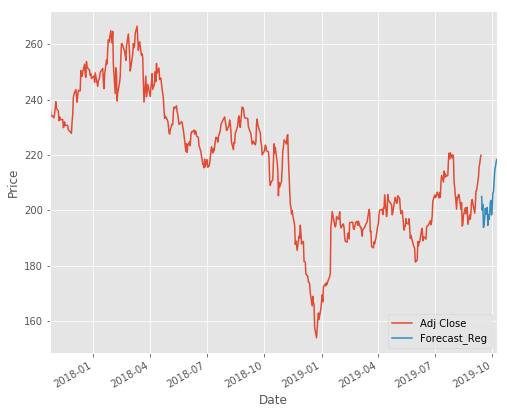

In [123]:
for i in forecast_reg:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast_Reg'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### Quadratic Regression 2 Prediction

#### Reset feature dataset

We have to reset dfreg before each prediction section, as it is adding dates each time

In [0]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))### drops last and stores the rest in X
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])  ## labels only in y
tempp=y
y = y[:-forecast_out]

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

#### Plot Prediction

In [125]:
forecast_poly2 = clfpoly2.predict(X_lately)
dfreg['Forecast_Poly2'] = np.nan

forecast_poly2

array([205.36614515, 200.2850254 , 203.53716604, 194.01590985,
       195.19125245, 198.3263718 , 200.86310992, 198.80622755,
       199.66962353, 201.14277637, 194.67428726, 198.36410971,
       197.09166828, 200.20680391, 203.05094935, 203.61027401,
       198.63244388, 201.44864899, 206.4102287 , 206.64903709,
       211.34070929, 214.18195417, 215.42627173, 217.48116598,
       217.81871585])

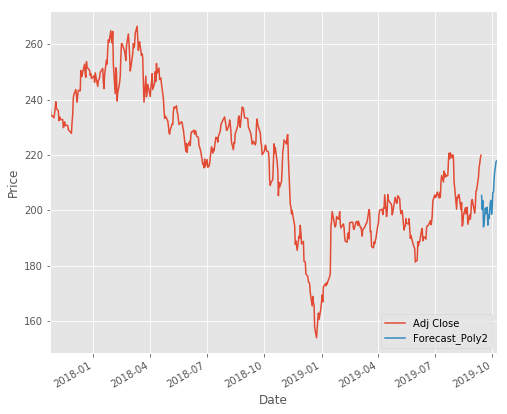

In [126]:
for i in forecast_poly2:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast_Poly2'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### Lasso Prediction

#### Reset feature dataset

In [0]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))### drops last and stores the rest in X
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])  ## labels only in y
tempp=y
y = y[:-forecast_out]

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

#### Plot prediction

In [128]:
forecast_lass = clflass.predict(X_lately)
dfreg['Forecast_Lass'] = np.nan

forecast_lass

array([204.90510181, 199.97966495, 202.11529014, 193.83163076,
       194.81191495, 197.87534034, 200.59659317, 198.55639122,
       199.32275274, 200.92852254, 194.64453472, 198.29976919,
       196.70565937, 198.90996614, 202.89063632, 203.45562213,
       198.3304993 , 201.33763152, 206.13477676, 206.58835485,
       210.58182377, 214.11856199, 215.47691868, 216.90705747,
       218.17888569])

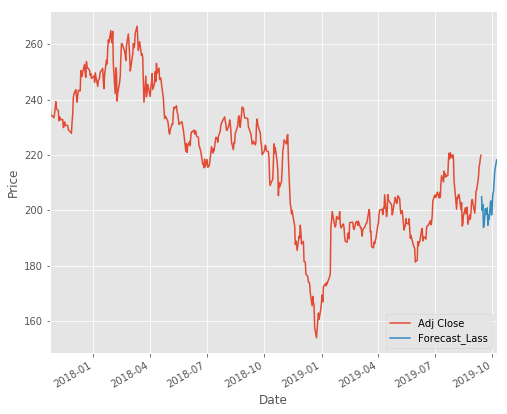

In [129]:
for i in forecast_lass:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast_Lass'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### Ridge Prediction

#### Reset feature dataset

In [0]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))### drops last and stores the rest in X
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])  ## labels only in y
tempp=y
y = y[:-forecast_out]

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

#### Plot Prediction

In [131]:
forecast_ridge = clfridge.predict(X_lately)
dfreg['Forecast_Ridge'] = np.nan

forecast_ridge

array([204.98510999, 200.05516777, 202.14472772, 193.83916702,
       194.89537254, 197.96641127, 200.70016688, 198.67297422,
       199.41884202, 201.04675625, 194.60794999, 198.44060226,
       196.75304807, 198.97336543, 203.00689128, 203.57962394,
       198.35651381, 201.46665464, 206.23042697, 206.71222997,
       210.64971807, 214.2298392 , 215.60205775, 216.98111924,
       218.32243271])

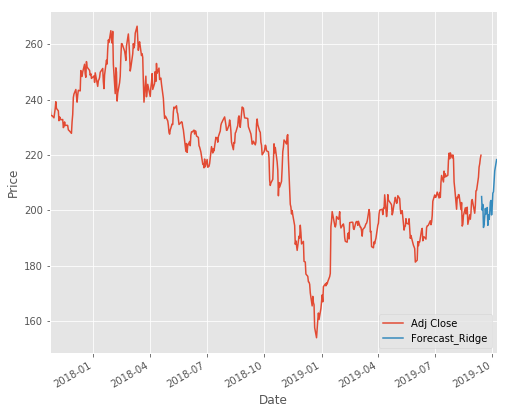

In [132]:
for i in forecast_ridge:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast_Ridge'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()